In [1]:
import torch as tc
# import torchsummary
!pip install torch-summary
import torchsummary

import matplotlib.pyplot as plt
!pip install monai
from monai import metrics

In [4]:


class EncoderDecoderExample(tc.nn.Module):
  def __init__(self, act_function=tc.nn.PReLU):
    tc.nn.Module.__init__(self)
    self.encoder = Encoder(act_function)
    self.decoder = Decoder()

  def get_embedding(self, x):
    return self.encoder(x)

  def forward(self, x):
    embedding = self.encoder(x)
    result = self.decoder(embedding)
    return result

class Encoder(tc.nn.Module):
  def __init__(self, act_function=tc.nn.PReLU):
    tc.nn.Module.__init__(self)
    input_channels = [3, 16, 32, 64]
    output_channels = [16, 32, 64, 128]
    kernel_sizes = [3, 3, 3, 3]
    strides = [2, 2, 2, 2]
    paddings = [1, 1, 1, 1]

    self.act_function = act_function

    self.num_channels = len(input_channels)
    for idx in range(self.num_channels):
      layer = tc.nn.Sequential(
        tc.nn.Conv2d(input_channels[idx],
                     output_channels[idx],
                     kernel_size=kernel_sizes[idx],
                     stride=strides[idx],
                     padding=paddings[idx]),
        tc.nn.BatchNorm2d(output_channels[idx]),
        act_function())
      setattr(self, f"layer_{idx}", layer)

  def forward(self, x):
    for idx in range(self.num_channels):
      layer = getattr(self, f"layer_{idx}")
      print(f"X shape: {x.shape}")
      x = layer(x)
    return x


class Decoder(tc.nn.Module):
  def __init__(self):
    tc.nn.Module.__init__(self)
    input_channels = [128, 64, 32, 16]
    output_channels = [64, 32, 16, 1]
    kernel_sizes = [3, 3, 3, 3]
    strides = [2, 2, 2, 2]
    paddings = [1, 1, 1, 1]
    output_paddings = [1, 1, 1, 1]

    self.num_channels = len(input_channels)
    for idx in range(self.num_channels):
      layer = tc.nn.Sequential(
        tc.nn.ConvTranspose2d(input_channels[idx],
                     output_channels[idx],
                     kernel_size=kernel_sizes[idx],
                     stride=strides[idx],
                     padding=paddings[idx],
                     output_padding=output_paddings[idx]),
        tc.nn.BatchNorm2d(output_channels[idx]),
        tc.nn.PReLU())
      setattr(self, f"layer_{idx}", layer)

  def forward(self, x):
    for idx in range(self.num_channels):
      layer = getattr(self, f"layer_{idx}")
      print(f"X shape: {x.shape}")
      x = layer(x)
    return x


# encoder = Encoder()

network = EncoderDecoderExample()

batch_size = 2
num_channels = 3
nrows = 128
ncols = 128
input_data = tc.randn((batch_size, num_channels, nrows, ncols))

# result = encoder(input_data)

result = network(input_data)

print(torchsummary.summary(network, input_data))

print(f"Result shape: {result.shape}")

X shape: torch.Size([2, 3, 128, 128])
X shape: torch.Size([2, 16, 64, 64])
X shape: torch.Size([2, 32, 32, 32])
X shape: torch.Size([2, 64, 16, 16])
X shape: torch.Size([2, 128, 8, 8])
X shape: torch.Size([2, 64, 16, 16])
X shape: torch.Size([2, 32, 32, 32])
X shape: torch.Size([2, 16, 64, 64])
X shape: torch.Size([2, 3, 128, 128])
X shape: torch.Size([2, 16, 64, 64])
X shape: torch.Size([2, 32, 32, 32])
X shape: torch.Size([2, 64, 16, 16])
X shape: torch.Size([2, 128, 8, 8])
X shape: torch.Size([2, 64, 16, 16])
X shape: torch.Size([2, 32, 32, 32])
X shape: torch.Size([2, 16, 64, 64])
Layer (type:depth-idx)                   Output Shape              Param #
├─Encoder: 1-1                           [-1, 128, 8, 8]           --
|    └─Sequential: 2-1                   [-1, 16, 64, 64]          --
|    |    └─Conv2d: 3-1                  [-1, 16, 64, 64]          448
|    |    └─BatchNorm2d: 3-2             [-1, 16, 64, 64]          32
|    |    └─PReLU: 3-3                   [-1, 16, 64

Text(0.5, 0.98, 'Dice: 0.75 HD: 25.0')

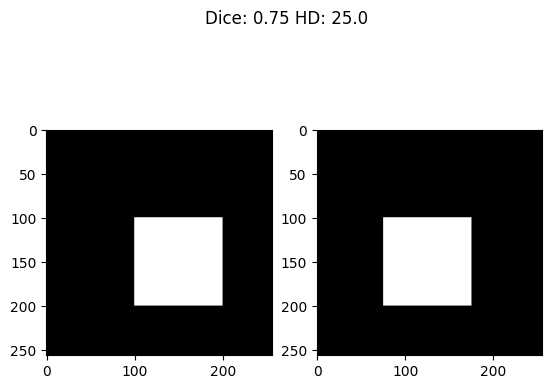

In [18]:
batch_size = 1
nchannels = 1
nrows = 256
ncols = 256

input_1 = tc.zeros((batch_size, nchannels, nrows, ncols))
input_2 = tc.zeros((batch_size, nchannels, nrows, ncols))

input_1[:, :, 100:200, 100:200] = 1
input_2[:, :, 100:200, 75:175] = 1 #100:150, 100:150

dice = metrics.DiceMetric()(input_1, input_2)
hd = metrics.compute_hausdorff_distance(input_1, input_2)


plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(input_1[0, 0, :, :], cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(input_2[0, 0, :, :], cmap='gray')
plt.suptitle(f"Dice: {dice.item()} HD: {hd.item()}")